In [ ]:
# Installs all dependencies from requirements.txt
!pip install -r requirements.txt

In [44]:
'''
This cell will attempt to create a csv file containing mappings of the image
file name along with its numerical label.
'''
import os  # For file path operations
import pandas as pd  # For data manipulation

# Define the path to the dataset
dataset_path = "frames"

# Define the categories
categories = ["norm", "weap"]  # 0 = norm, 1 = weap

# Loop through the categories and the train/test folders
for category in categories:
    for folder in ["train", "test"]:
        # Initialize an empty list to store the data
        data = []

        folder_path = os.path.join(dataset_path, folder, category)
        for filename in os.listdir(folder_path):
            # Append the filename and the label to the data list
            label = 1 if category == "weap" else 0
            data.append((os.path.join(category, filename), label))

        # Create a Pandas DataFrame from the data list
        df = pd.DataFrame(data, columns=["filename", "label"])

        # Save the DataFrame to a CSV file
        df.to_csv(f"{folder}_annotations.csv", index=False)

In [45]:
import torch  # For building the models

# Environment Information
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Devices Detected: {torch.cuda.device_count()}")
print(f"1st GPU Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.2.0.dev20231101+cu121
GPU Devices Detected: 1
1st GPU Device Name: NVIDIA GeForce RTX 4090


In [46]:
# Types of Data
from torch.utils.data import Dataset
from torchvision.io import read_image

# Class for Custom Image Dataset


class CustomImageDataset(Dataset):
    # https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = str(self.img_labels.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [47]:
from torchvision.transforms import Compose, Grayscale, Resize

# Define the transforms
transform = Compose([
    Grayscale(num_output_channels=1),
    Resize((512, 512)),
])

# Apply the transforms to the dataset
training_data = CustomImageDataset(
    "train_annotations.csv", "./frames/train/", transform=transform, target_transform=None)
test_data = CustomImageDataset(
    "test_annotations.csv", "./frames/test/", transform=transform, target_transform=None)

In [48]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 512, 512])
Labels batch shape: torch.Size([64])


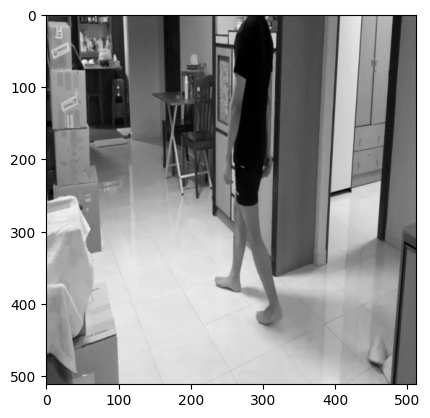

Label: 1


In [49]:

import matplotlib.pyplot as plt  # For visualization

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")